In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pickle

In [9]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/05/05 11:43:22 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/deji/mlruns/1', creation_time=1746445402512, experiment_id='1', last_update_time=1746445402512, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

/tmp/ipykernel_1703/12427667.py:52: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1703/12427667.py:53: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='actual')


(<module 'matplotlib.pyplot' from '/home/deji/mlops-env/lib/python3.13/site-packages/matplotlib/pyplot.py'>,
 np.float64(7.758715209663881))

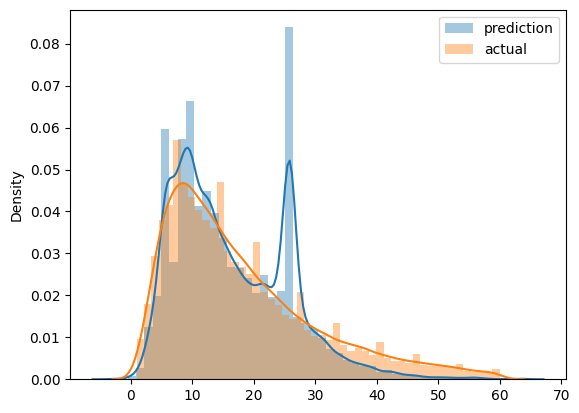

In [13]:
def read_dataframe(training_data, validation_data):
    df_train = pd.read_parquet(training_data)
    df_val = pd.read_parquet(validation_data)
    
    df_train["duration"] = df_train.lpep_dropoff_datetime - df_train.lpep_pickup_datetime
    df_val["duration"] = df_val.lpep_dropoff_datetime - df_val.lpep_pickup_datetime
    
    #Convert duration to minutes
    df_train.duration = (df_train.duration.dt.total_seconds() / 60)
    df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]

    df_val.duration = (df_val.duration.dt.total_seconds() / 60)
    df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

    df_train["PU_DO"] = df_train.PULocationID.astype(str) + '_' + df_train.DOLocationID.astype(str)
    df_val["PU_DO"] = df_val.PULocationID.astype(str) + '_' + df_val.DOLocationID.astype(str)
    
    #categorical = ['PULocationID', 'DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']

    # PULocationID and DOLocationID are actually categorical, so we must change them from int64 to string
    df_train[categorical] = df_train[categorical].astype(str)
    df_val[categorical] = df_val[categorical].astype(str)

    dv = DictVectorizer()
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    X_train = dv.fit_transform(train_dicts)

    val_dicts = df_val[categorical + numerical].to_dict(orient='records')

    X_val = dv.transform(val_dicts)

    target = 'duration'
    y_train = df_train[target].values
    y_val = df_val[target].values

    with mlflow.start_run():

        mlflow.set_tag("developer", "deji")

        mlflow.log_param("train-data-path", "data/green_tripdata_2021-01.parquet")
        mlflow.log_param("validation-data-path", "data/green_tripdata_2021-02.parquet")

        alpha = 0.01
    
        lr = LinearRegression()
        lr.fit(X_train, y_train)
    
        y_pred = lr.predict(X_val)
    
        sns.distplot(y_pred, label='prediction')
        sns.distplot(y_val, label='actual')
        plt.legend()
    
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    with open('models/lin_reg.bin', 'wb') as f_out:
        pickle.dump((dv, lr), f_out) 

    return plt, rmse
read_dataframe('data/green_tripdata_2021-01.parquet', 'data/green_tripdata_2021-02.parquet')